In [1]:
import pydot
import matplotlib.pyplot as plt
import time
import math
import random
from sklearn.manifold import MDS
import numpy as np
import plotly.graph_objs as go
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.manifold import Isomap
from sklearn.metrics import euclidean_distances


# Metrics TSNE

In [47]:
#run "Step6.ipynb"

# T-sne with divergence values

In [48]:
def plot_tsne(distances, node_list, edge_list, perplexity=10, learning_rate=300, n_iter=750, interactive=False):
    tsne = TSNE(n_components=2, perplexity=perplexity, learning_rate=learning_rate, n_iter=n_iter, init='pca')
    embeddings = tsne.fit_transform(distances)

    
    kl_div = tsne.kl_divergence_
    for i in range(n_iter):
        print(f"Iteration {i+1}: KL divergence = {kl_div}")
        if kl_div < 0.05:
            print(f"t-SNE has converged in iteration n. {i+1}")
            break

    # KMeans clustering
    # kmeans = KMeans(n_clusters=8)  # You can adjust the number of clusters
    # labels = kmeans.fit_predict(embeddings)

    plt.figure(figsize=(10, 8))
    #plt.scatter(embeddings[:, 0], embeddings[:, 1], c=labels, cmap='viridis', s=50)
    plt.scatter(embeddings[:, 0], embeddings[:, 1], cmap='viridis', s=50)

    for edge in edge_list:
        u, v = edge
        u_index = node_list.index(u)
        v_index = node_list.index(v)
        plt.plot([embeddings[u_index, 0], embeddings[v_index, 0]], 
                    [embeddings[u_index, 1], embeddings[v_index, 1]], 
                    color='gray', alpha=0.2)

    for i, node_number in enumerate(node_list):
        plt.text(embeddings[i, 0], embeddings[i, 1], node_number, color='black')

    plt.title('t-SNE Visualization of Node Similarities')
    plt.xlabel('t-SNE Dimension 1')
    plt.ylabel('t-SNE Dimension 2')
    plt.grid(True)
    #plt.colorbar(label='Cluster ID')
    plt.colorbar(label='Similarity')
    plt.show()

# Similarity matrix (trash)

In [5]:
def compute_similarity_matrix(node_list, edge_list, weights):
    edge_weights = {(u, v): weight for (u, v), weight in weights.items()}

    num_nodes = len(node_list)
    distances = np.zeros((num_nodes, num_nodes))
    for i, source in enumerate(node_list):
        for j, target in enumerate(node_list):
            if i != j:
                if (source, target) in edge_weights:
                    distances[i, j] = edge_weights[(source, target)]
                elif (target, source) in edge_weights:
                    distances[i, j] = edge_weights[(target, source)]
                else:
                    distances[i, j] = np.inf

    similarities = np.zeros((num_nodes, num_nodes))
    for u, v in edge_list:
        i = node_list.index(u)
        j = node_list.index(v)
        similarities[i, j] = 1 / (1 + distances[i, j])
        similarities[j, i] = similarities[i, j]  # Similarity matrix is symmetric

    np.fill_diagonal(similarities, 1) #diagonal 1

    return similarities

similarity_matrix = compute_similarity_matrix(node_list, edge_list, weights)

#print("Similarity matrix:")
#print("\t" + "\t".join(node_list))
#for i in range(len(node_list)):
#    print(node_list[i], "\t", end="")
#    for j in range(len(node_list)):
#        print("{:.2f}".format(similarity_matrix[i, j]), "\t", end="")
#    print()

similarities = compute_similarity_matrix(node_list, edge_list, weights)


# Floyd Warshall

In [49]:
def floyd_warshall(node_list, edge_list, weights):
    num_nodes = len(node_list)
    
    distances = np.full((num_nodes, num_nodes), np.inf)
    np.fill_diagonal(distances, 0)

    for (u, v), weight in weights.items():
        i = node_list.index(u)
        j = node_list.index(v)
        distances[i, j] = weight
        distances[j, i] = weight  # If the graph is undirected

    for k in range(num_nodes):
        for i in range(num_nodes):
            for j in range(num_nodes):
                distances[i, j] = min(distances[i, j], distances[i, k] + distances[k, j])

    return distances

distances = floyd_warshall(node_list, edge_list, weights)
print(distances)


[[ 0.  1.  9. ...  9.  9. 11.]
 [ 1.  0.  8. ...  8.  8. 10.]
 [ 9.  8.  0. ...  6.  6.  8.]
 ...
 [ 9.  8.  6. ...  0.  5.  5.]
 [ 9.  8.  6. ...  5.  0.  8.]
 [11. 10.  8. ...  5.  8.  0.]]


# Jazz example (trash)


In [50]:
nodes,edges,node_list,edge_list,weights = get_data_step6('Datasets/JazzNetwork.dot')

#print(nodes) 
#print(edges)
#print(node_list)
#print(edge_list)
#print(weights)

In [51]:
def compute_similarity_matrix(node_list, edge_list): #no wweights
    num_nodes = len(node_list)
    
    distances = np.full((num_nodes, num_nodes), np.inf)
    
    for u, v in edge_list:
        i = node_list.index(u)
        j = node_list.index(v)
        distances[i, j] = 1
        distances[j, i] = 1
    
    similarities = np.zeros((num_nodes, num_nodes))
    for i in range(num_nodes):
        for j in range(num_nodes):
            if i != j:
                similarities[i, j] = 1 / (1 + distances[i, j])
    
    np.fill_diagonal(similarities, 1)
    
    return similarities

similarities = compute_similarity_matrix(node_list, edge_list)

#print("Similarity matrix:")
#print("\t" + "\t".join(node_list))
#for i in range(len(node_list)):
#    print(node_list[i], "\t", end="")
#    for j in range(len(node_list)):
#        print("{:.2f}".format(similarities[i, j]), "\t", end="")
#    print()



In [52]:
#plot_tsne(similarities, node_list, edge_list, perplexity=15, learning_rate=250, n_iter=1500, interactive=False)

# League example (trash)

In [53]:
nodes,edges,node_list,edge_list,weights = get_data_league('Datasets/LeagueNetwork.dot')

#print(nodes) 
#print(edges)
#print(node_list)
#print(edge_list)
#print(weights)

In [54]:
def compute_similarity_matrix_league(node_list, edge_list, weights):
    edge_weights = {(u, v): weight for (u, v), weight in weights.items()}

    num_nodes = len(node_list)
    distances = np.zeros((num_nodes, num_nodes))
    
    for i, source in enumerate(node_list):
        for j, target in enumerate(node_list):
            if i != j:
                if (source, target) in edge_weights:
                    distances[i, j] = edge_weights[(source, target)]
                else:
                    distances[i, j] = -edge_weights[(target, source)] if (target, source) in edge_weights else np.inf

    similarities = np.zeros((num_nodes, num_nodes))
    for u, v in edge_list:
        i = node_list.index(u)
        j = node_list.index(v)
        similarities[i, j] = 1 / (1 + abs(distances[i, j])) if distances[i, j] != np.inf else 0 
        similarities[j, i] = similarities[i, j]  

    np.fill_diagonal(similarities, 1)  # Diagonal set to 1

    return similarities

similarities = compute_similarity_matrix_league(node_list, edge_list, weights)

#print("Similarity matrix:")
#print("\t" + "\t".join(node_list))
#for i in range(len(node_list)):
#    print(node_list[i], "\t", end="")
#    for j in range(len(node_list)):
#        print("{:.2f}".format(similarities[i, j]), "\t", end="")
#    print()

In [55]:
#plot_tsne(similarities, node_list, edge_list, perplexity=10, learning_rate=200, n_iter=1000, interactive=False)

# Testing

### Metrics miserables

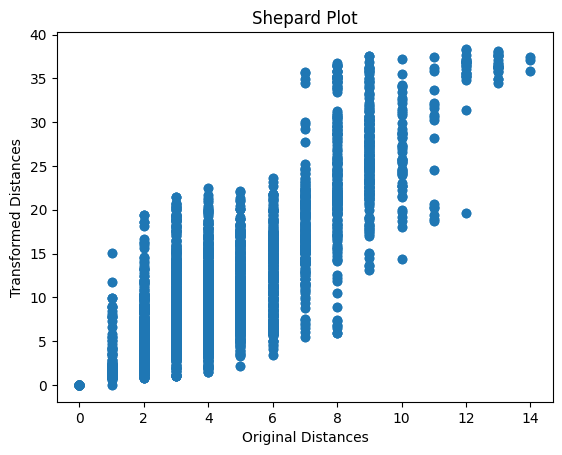

Continuity 0.90351966873706
Trustworthiness 0.9450028232636928
Stress 3.4608009930586077


/var/folders/pp/bdyt1jrd5w5d3twfkg227dtc0000gn/T/ipykernel_60450/240869735.py:141: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(embeddings[:, 0], embeddings[:, 1], cmap='viridis', s=50)


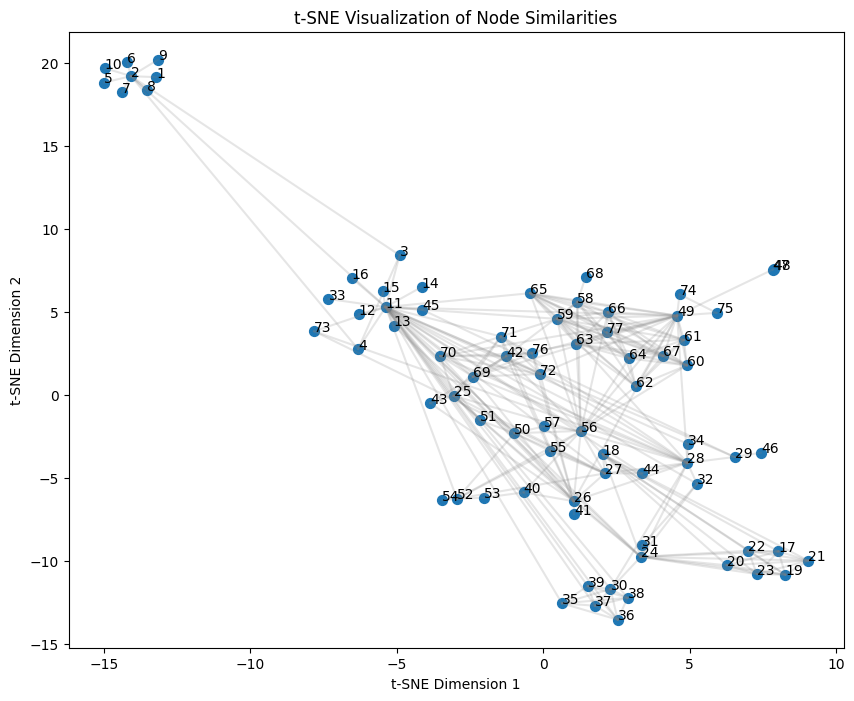

In [50]:
def compute_continuity(similarities, distances_Y, k=5):
    """
    Compute continuity metric for t-SNE projection.

    Parameters:
    - similarities: Similarity matrix for the high-dimensional data.
    - distances_Y: Euclidean distances for the t-SNE projected points in 2D space.
    - k: Number of neighbors to consider.

    Returns:
    - Continuity score.
    """
    n = len(similarities)

    nn_orig = similarities.argsort()
    nn_proj = distances_Y.argsort()

    knn_orig = nn_orig[:, :k + 1][:, 1:]
    knn_proj = nn_proj[:, :k + 1][:, 1:]

    sum_i = 0

    for i in range(n):
        V = np.setdiff1d(knn_orig[i], knn_proj[i])

        sum_j = 0
        for j in range(V.shape[0]):
            sum_j += np.where(nn_proj[i] == V[j])[0] - k

        sum_i += sum_j

    return float((1 - (2 / (n * k * (2 * n - 3 * k - 1)) * sum_i)).squeeze())

def compute_trustworthiness(similarities, distances_Y, k=5):
    """
    Compute trustworthiness metric for t-SNE projection.

    Parameters:
    - similarities: Similarity matrix for the high-dimensional data.
    - distances_Y: Euclidean distances for the t-SNE projected points in 2D space.
    - k: Number of neighbors to consider.

    Returns:
    - Trustworthiness score.
    """
    n = len(similarities)

    nn_orig = similarities.argsort()
    nn_proj = distances_Y.argsort()

    knn_orig = nn_orig[:, :k + 1][:, 1:]
    knn_proj = nn_proj[:, :k + 1][:, 1:]

    sum_i = 0

    for i in range(n):
        U = np.setdiff1d(knn_proj[i], knn_orig[i])

        sum_j = 0
        for j in range(U.shape[0]):
            sum_j += np.where(nn_orig[i] == U[j])[0] - k

        sum_i += sum_j

    trustworthiness_score = float((1 - (2 / (n * k * (2 * n - 3 * k - 1)) * sum_i)).squeeze())
    return trustworthiness_score

def compute_stress(similarities, distances_Y):
    
    #print(f"similarities: {similarities}")
    #print(f"distances_Y: {distances_Y}")
    #n = len(similarities)
    
    # Create a mask to ignore the diagonal and only consider the lower triangular part
    #mask = np.tri(n, k=-1)
    stress = np.sum((similarities - distances_Y)**2) / np.sum(similarities**2)
    #stress = np.sum((similarities - distances_Y)**2 * mask) / np.sum(similarities**2 * mask)

    return stress

def compute_shepard(distances, distances_Y):
    
    plt.scatter(distances.flatten(), distances_Y.flatten())
    plt.xlabel('Original Distances')
    plt.ylabel('Transformed Distances')
    plt.title('Shepard Plot')
    plt.show()

#def metric_pq_shepard_diagram_correlation(id_run, dataset_name):
#    global DISTANCES
#
#    D_high = np.load(DISTANCES['D_high_list'], mmap_mode='c')
#    D_low = np.load(DISTANCES[id_run]['D_low_list'], mmap_mode='c')
#
#    return stats.spearmanr(D_high, D_low)[0]

def floyd_warshall(node_list, edge_list, weights):
    num_nodes = len(node_list)
    
    distances = np.full((num_nodes, num_nodes), np.inf)

    np.fill_diagonal(distances, 0)

    for (u, v), weight in weights.items():
        i = node_list.index(u)
        j = node_list.index(v)
        distances[i, j] = weight
        distances[j, i] = weight  # If the graph is undirected

    for k in range(num_nodes):
        for i in range(num_nodes):
            for j in range(num_nodes):
                distances[i, j] = min(distances[i, j], distances[i, k] + distances[k, j])

    return distances

def plot_tsne_testing(distances, node_list, edge_list, perplexity=10, learning_rate=30, n_iter=1000):
    tsne = TSNE(n_components=2, perplexity=perplexity, learning_rate=learning_rate, n_iter=n_iter, init='random', metric='precomputed')
    embeddings = tsne.fit_transform(distances)
    #print(f"Embeddings: {embeddings.flatten()}")
    distances_Y = euclidean_distances(embeddings)
    #print(f"Embeddings: {distances_Y}")
    #print(f"Distances: {distances}")
    #kl_div = tsne.kl_divergence_
    #for i in range(n_iter):
    #    print(f"Iteration {i+1}: KL divergence = {kl_div}")
    #    if kl_div < 0.05:
    #        print(f"t-SNE has converged in iteration n. {i+1}")
    #        break

    continuity_score = compute_continuity(distances, distances_Y)
    trustworthiness_score = compute_trustworthiness(distances, distances_Y)
    stress = compute_stress(distances, distances_Y)
    shepard_values = compute_shepard(distances, distances_Y)

    print(f"Continuity {continuity_score}")
    print(f"Trustworthiness {trustworthiness_score}")
    print(f"Stress {stress}")

    plt.figure(figsize=(10, 8))
    plt.scatter(embeddings[:, 0], embeddings[:, 1], cmap='viridis', s=50)

    for edge in edge_list:
        u, v = edge
        u_index = node_list.index(u)
        v_index = node_list.index(v)
        plt.plot([embeddings[u_index, 0], embeddings[v_index, 0]], 
                 [embeddings[u_index, 1], embeddings[v_index, 1]], 
                 color='gray', alpha=0.2)

    for i, node_number in enumerate(node_list):
        plt.text(embeddings[i, 0], embeddings[i, 1], node_number, color='black')

    plt.title('t-SNE Visualization of Node Similarities')
    plt.xlabel('t-SNE Dimension 1')
    plt.ylabel('t-SNE Dimension 2')
    #plt.grid(True)
    #plt.colorbar(label='Similarity')
    plt.show()

nodes, edges, node_list, edge_list, weights = get_data_step6('Datasets/LesMiserables.dot')
distances = floyd_warshall(node_list, edge_list, weights)
plot_tsne_testing(distances, node_list, edge_list, perplexity=10,learning_rate=20, n_iter=1000)


### Metrics League

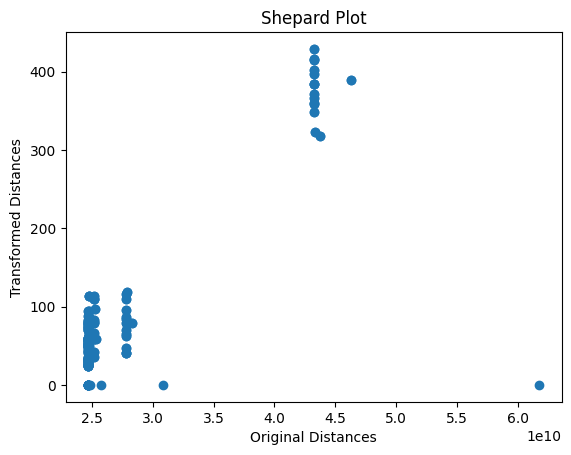

Continuity 0.8828125
Trustworthiness 0.81875
Stress 0.999999992042984


/var/folders/pp/bdyt1jrd5w5d3twfkg227dtc0000gn/T/ipykernel_60450/1021390175.py:26: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(embeddings[:, 0], embeddings[:, 1], cmap='viridis', s=50)


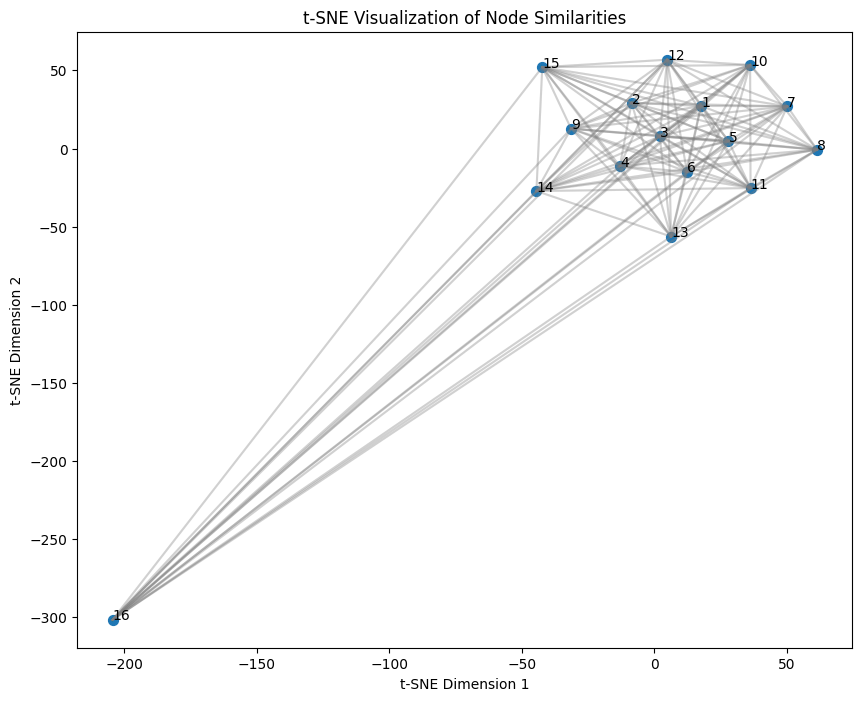

In [51]:
def plot_tsne_testing_league(distances, node_list, edge_list, perplexity=10, learning_rate=30, n_iter=1000):
    tsne = TSNE(n_components=2, perplexity=perplexity, learning_rate=learning_rate, n_iter=n_iter, init='random', metric="precomputed")
    distances = np.abs(distances)
    embeddings = tsne.fit_transform(distances)
    #print(f"Embeddings: {embeddings.flatten()}")
    distances_Y = euclidean_distances(embeddings)
    #print(f"Embeddings: {distances_Y}")
    #print(f"Distances: {distances}")
    #kl_div = tsne.kl_divergence_
    #for i in range(n_iter):
    #    print(f"Iteration {i+1}: KL divergence = {kl_div}")
    #    if kl_div < 0.05:
    #        print(f"t-SNE has converged in iteration n. {i+1}")
    #        break

    continuity_score = compute_continuity(distances, distances_Y)
    trustworthiness_score = compute_trustworthiness(distances, distances_Y)
    stress = compute_stress(distances, distances_Y)
    shepard_values = compute_shepard(distances, distances_Y)

    print(f"Continuity {continuity_score}")
    print(f"Trustworthiness {trustworthiness_score}")
    print(f"Stress {stress}")

    plt.figure(figsize=(10, 8))
    plt.scatter(embeddings[:, 0], embeddings[:, 1], cmap='viridis', s=50)

    for edge in edge_list:
        u, v = edge
        u_index = node_list.index(u)
        v_index = node_list.index(v)
        plt.plot([embeddings[u_index, 0], embeddings[v_index, 0]], 
                 [embeddings[u_index, 1], embeddings[v_index, 1]], 
                 color='gray', alpha=0.2)

    for i, node_number in enumerate(node_list):
        plt.text(embeddings[i, 0], embeddings[i, 1], node_number, color='black')

    plt.title('t-SNE Visualization of Node Similarities')
    plt.xlabel('t-SNE Dimension 1')
    plt.ylabel('t-SNE Dimension 2')
    #plt.grid(True)
    #plt.colorbar(label='Similarity')
    plt.show()

nodes, edges, node_list, edge_list, weights = get_data_league('Datasets/LeagueNetwork.dot')
distances = floyd_warshall(node_list, edge_list, weights)
plot_tsne_testing_league(distances, node_list, edge_list, perplexity=10,learning_rate=30, n_iter=1000)

### Metrics Jazz

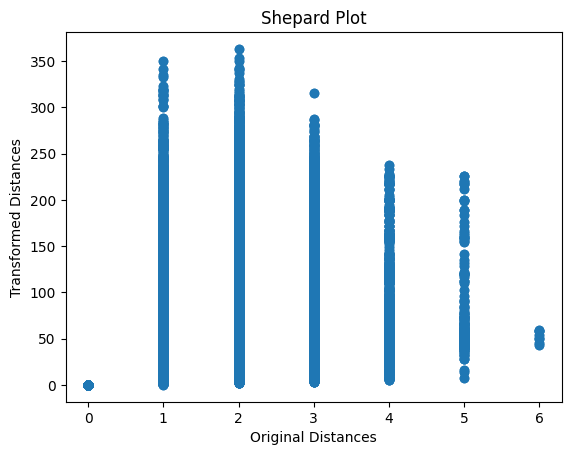

Continuity 0.7148112706007443
Trustworthiness 0.7868367889420521
Stress 2179.456721267099


/var/folders/pp/bdyt1jrd5w5d3twfkg227dtc0000gn/T/ipykernel_60450/3401058797.py:41: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(embeddings[:, 0], embeddings[:, 1], cmap='viridis', s=50)


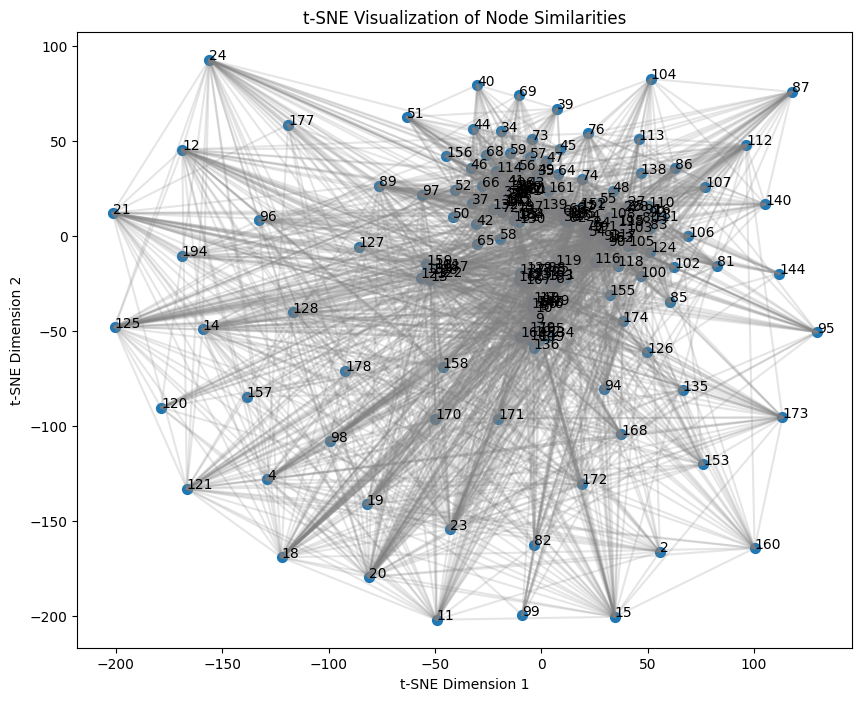

In [42]:
def get_data_jazz(dot_file_path):
    #= 'Datasets/LesMiserables.dot'
    with open(dot_file_path, 'r') as dot_file:
        dot_data = dot_file.read()
    graph = pydot.graph_from_dot_data(dot_data)

    nodes = graph[0].get_nodes()
    edges = graph[0].get_edges()
    
    node_list = [node.get_name() for node in nodes]
    edge_list = [(edge.get_source(), edge.get_destination()) for edge in edges]
    weights = {(edge.get_source(), edge.get_destination()):1 for edge in edges}
    
    return nodes,edges,node_list,edge_list,weights


def plot_tsne_testing_league(distances, node_list, edge_list, perplexity=10, learning_rate=30, n_iter=1000):
    tsne = TSNE(n_components=2, perplexity=perplexity, learning_rate=learning_rate, n_iter=n_iter, init='random', metric="precomputed")
    embeddings = tsne.fit_transform(distances)
    #print(f"Embeddings: {embeddings.flatten()}")
    distances_Y = euclidean_distances(embeddings)
    #print(f"Embeddings: {distances_Y}")
    #print(f"Distances: {distances}")
    #kl_div = tsne.kl_divergence_
    #for i in range(n_iter):
    #    print(f"Iteration {i+1}: KL divergence = {kl_div}")
    #    if kl_div < 0.05:
    #        print(f"t-SNE has converged in iteration n. {i+1}")
    #        break

    continuity_score = compute_continuity(distances, distances_Y)
    trustworthiness_score = compute_trustworthiness(distances, distances_Y)
    stress = compute_stress(distances, distances_Y)
    shepard_values = compute_shepard(distances, distances_Y)

    print(f"Continuity {continuity_score}")
    print(f"Trustworthiness {trustworthiness_score}")
    print(f"Stress {stress}")

    plt.figure(figsize=(10, 8))
    plt.scatter(embeddings[:, 0], embeddings[:, 1], cmap='viridis', s=50)

    for edge in edge_list:
        u, v = edge
        u_index = node_list.index(u)
        v_index = node_list.index(v)
        plt.plot([embeddings[u_index, 0], embeddings[v_index, 0]], 
                 [embeddings[u_index, 1], embeddings[v_index, 1]], 
                 color='gray', alpha=0.2)

    for i, node_number in enumerate(node_list):
        plt.text(embeddings[i, 0], embeddings[i, 1], node_number, color='black')

    plt.title('t-SNE Visualization of Node Similarities')
    plt.xlabel('t-SNE Dimension 1')
    plt.ylabel('t-SNE Dimension 2')
    #plt.grid(True)
    #plt.colorbar(label='Similarity')
    plt.show()

nodes, edges, node_list, edge_list, weights = get_data_jazz('Datasets/Jazznetwork.dot')
#print(weights)
distances = floyd_warshall(node_list, edge_list, weights)
plot_tsne_testing_league(distances, node_list, edge_list, perplexity=10,learning_rate=100, n_iter=1000)